In [1]:
import pandas as pd
import numpy as np
import math
import chart_studio.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, mean_squared_error, f1_score, matthews_corrcoef, classification_report, roc_curve, auc



In [2]:
# Load model from file
#xnn_dir = '/home/kimm/article-information-2019/data/xnn_output/hmda_results/'
#xnn_dir = '/Users/kmontgomery/Documents/git/article-information-2019/data/xnn_output/hmda_results/'
xnn_dir = '/Users/phall/workspace/article-information-2019/data/xnn_output/hmda_results/'

label = "BLDS_run100"

filename = 'main_15000_' + label + '.csv'

TEST = pd.read_csv(xnn_dir + filename)

Feature_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing','loan_amount_std', 
                 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'intro_rate_period_std',
                 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

In [3]:
TEST.columns

Index(['Unnamed: 0', 'high_priced', 'term_360', 'conforming', 'black', 'asian',
       'white', 'amind', 'hipac', 'hispanic', 'non_hispanic', 'male', 'female',
       'agegte62', 'agelt62', 'debt_to_income_ratio_missing',
       'loan_amount_std', 'loan_to_value_ratio_std',
       'no_intro_rate_period_std', 'intro_rate_period_std',
       'property_value_std', 'income_std', 'debt_to_income_ratio_std', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype='object')

In [4]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y 
        and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values.
        
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y)          # column for predicted decisions
    eps = 1e-20                    # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]

        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame

# calculate and display recall and precision
#prauc_frame = get_prauc(test_yhat, y, yhat)
prauc_frame = get_prauc(TEST, 'high_priced', '0')
prauc_frame.style.set_caption('Recall and Precision')

,cutoff,recall,precision,f1
0,0,0.999741,0.0976096,0.177854
1,0.01,0.974405,0.15516,0.267694
2,0.02,0.957084,0.175044,0.295959
3,0.03,0.942089,0.191507,0.318309
4,0.04,0.921665,0.20746,0.338685
5,0.05,0.900982,0.223469,0.358115
6,0.06,0.881851,0.239335,0.37649
7,0.07,0.858583,0.25326,0.391143
8,0.08,0.839193,0.265782,0.403706
9,0.09,0.817994,0.277398,0.414299


In [5]:
# Find the max F1 cutoff to be used in the accuracy calculation

xnn_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # value associated w/ index of max. F1
print('Best F1 threshold: %.2f' % xnn_cut)

Best F1 threshold: 0.24


In [6]:
# Calculate test statistics
Prediction = list(TEST['0'])
Classification = list(TEST['0'].apply(lambda x: int(x >= 0.24)))
Actual = list(TEST['high_priced'].apply(int))

test_statistics = {}

#classification_rep = classification_report(Actual, Classification, output_dict=True)
classification_rep = classification_report(Actual, Classification, digits=3)

test_statistics['AUC'] = roc_auc_score(Actual, Prediction)
test_statistics['accuracy_score'] = accuracy_score(Actual, Classification)
test_statistics['log_loss'] = log_loss(Actual, Prediction)
test_statistics['rmse'] = math.sqrt(mean_squared_error(Actual, Prediction))
test_statistics['mcc'] = matthews_corrcoef(Actual, Classification)
#test_statistics['precision'] = classification_rep[1]['precision']
#test_statistics['sensitivity'] = classification_rep[1]['recall']
test_statistics['F1'] = f1_score(Actual, Classification)

print(test_statistics)

{'AUC': 0.8678424054305, 'accuracy_score': 0.8685895819676265, 'log_loss': 0.23345289360148078, 'rmse': 0.26303913044949423, 'mcc': 0.4091994247849463, 'F1': 0.4684886803997553}


In [7]:
# recall of the positive class is also known as “sensitivity”
# recall of the negative class is “specificity”
print(classification_rep)

             precision    recall  f1-score   support

          0      0.953     0.898     0.925     35794
          1      0.387     0.594     0.468      3868

avg / total      0.898     0.869     0.881     39662



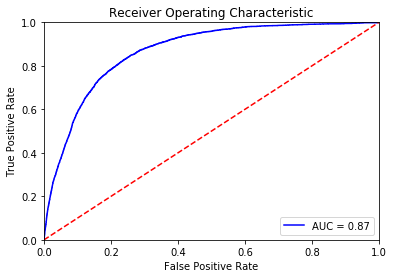

In [8]:
fpr, tpr, threshold = roc_curve(Actual, Prediction)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [8]:
# Shapley and prediction matrix

SHAPLEY = TEST[[str(col) for col in range(0,12)]].copy()

# Take the absolute value of the Shapley values

for col in range(1, 12):
    SHAPLEY[str(col)] = SHAPLEY[str(col)].apply(abs)
    
Global_Shapley_Feature_Importance = SHAPLEY[[str(col) for col in range(1,12)]].mean()
Global_Shapley_Feature_Importance.index = Feature_names + ['Intercept']
# Global_Shapley_Feature_Importance = Global_Shapley_Feature_Importance.sort_values(ascending=False)

In [9]:
print("Global Shapley Feature Importance")

Global_Shapley_Feature_Importance 



Global Shapley Feature Importance


term_360                        0.000939
conforming                      0.001832
debt_to_income_ratio_missing    0.000098
loan_amount_std                 0.091109
loan_to_value_ratio_std         0.069885
no_intro_rate_period_std        0.086347
intro_rate_period_std           0.077052
property_value_std              0.099896
income_std                      0.015983
debt_to_income_ratio_std        0.014954
Intercept                       0.068418
dtype: float64

In [10]:
Feature_importance = pd.DataFrame(Global_Shapley_Feature_Importance)

In [39]:
SHAPLEY.iloc[0:4,]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.173008,0.000624,0.000343,0.0,0.000443,0.123565,0.023575,0.027872,0.041322,0.018440,0.082873,0.068418
1,0.038878,0.000133,0.000727,0.0,0.056954,0.036275,0.810829,0.856231,0.068758,0.002783,0.012252,0.068418
2,0.384606,0.001084,0.000335,0.0,0.186659,0.223789,0.040831,0.047227,0.205099,0.020906,0.045908,0.068418
3,0.000521,0.006141,0.000096,0.0,0.006908,0.027597,0.012200,0.011565,0.025468,0.000478,0.000574,0.068418


In [40]:
# Calculate the average Shapley values for each quintile

SHAPLEY = SHAPLEY.sort_values('0')
len_Quintile=int(len(SHAPLEY)/5)

quintile_dict = {}
for quintile in range(1, 6):
    if quintile == 5:
        QUINTILE = SHAPLEY.iloc[(len_Quintile * (quintile - 1)):, 1:12].copy()
    else:
        QUINTILE = SHAPLEY.iloc[(len_Quintile * (quintile - 1)):(len_Quintile*quintile), 1:12].copy()
        
    QUINTILE = QUINTILE.mean()
    QUINTILE.index = Feature_names + ['Intercept']
    # QUINTILE = QUINTILE.sort_values(ascending=False)
    quintile_dict[quintile] = QUINTILE
    Feature_importance['Quintile '+str(quintile)] = QUINTILE
    print(quintile_dict[quintile])



term_360                        0.001586
conforming                      0.001852
debt_to_income_ratio_missing    0.000002
loan_amount_std                 0.017668
loan_to_value_ratio_std         0.043951
no_intro_rate_period_std        0.025870
intro_rate_period_std           0.023711
property_value_std              0.041305
income_std                      0.008072
debt_to_income_ratio_std        0.005996
Intercept                       0.068418
dtype: float64
term_360                        0.000587
conforming                      0.002882
debt_to_income_ratio_missing    0.000009
loan_amount_std                 0.052857
loan_to_value_ratio_std         0.045348
no_intro_rate_period_std        0.061389
intro_rate_period_std           0.058826
property_value_std              0.067599
income_std                      0.009774
debt_to_income_ratio_std        0.007228
Intercept                       0.068418
dtype: float64
term_360                        0.000611
conforming                 

In [41]:
Feature_importance = Feature_importance.rename(columns={"0": "Global Feature_Importance"})

Feature_importance.to_csv(xnn_dir + "Results_hmda_Feature_Importance.csv")

Feature_importance

,0,Quintile 1,Quintile 2,Quintile 3,Quintile 4,Quintile 5
term_360,0.000939,0.001586,0.000587,0.000611,0.000821,0.001090
conforming,0.001832,0.001852,0.002882,0.001575,0.001615,0.001233
debt_to_income_ratio_missing,0.000098,0.000002,0.000009,0.000080,0.000160,0.000240
loan_amount_std,0.091109,0.017668,0.052857,0.137062,0.095144,0.152797
loan_to_value_ratio_std,0.069885,0.043951,0.045348,0.029260,0.027177,0.203657
no_intro_rate_period_std,0.086347,0.025870,0.061389,0.102655,0.076919,0.164883
intro_rate_period_std,0.077052,0.023711,0.058826,0.100319,0.065077,0.137312
property_value_std,0.099896,0.041305,0.067599,0.146438,0.103522,0.140604
income_std,0.015983,0.008072,0.009774,0.011857,0.018052,0.032156
debt_to_income_ratio_std,0.014954,0.005996,0.007228,0.011083,0.015587,0.034871


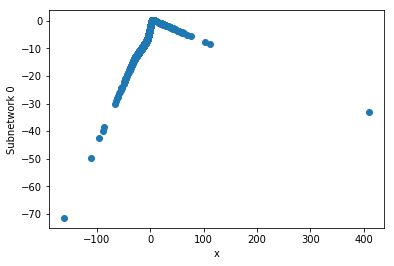

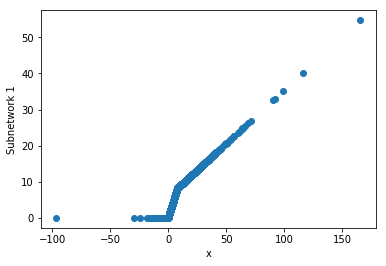

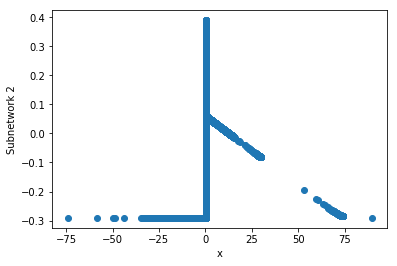

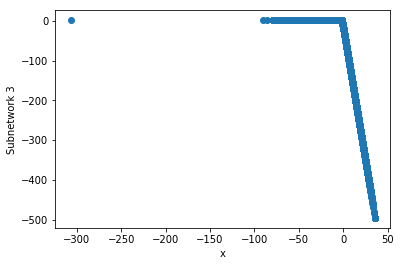

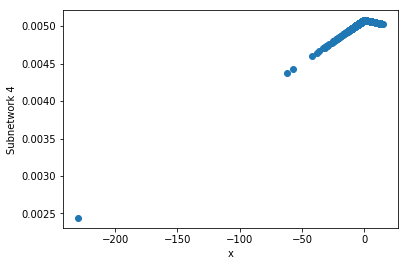

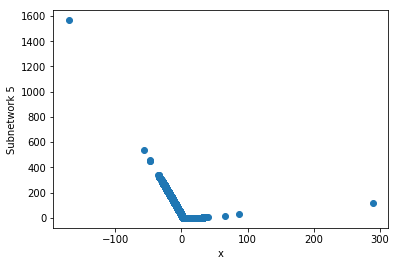

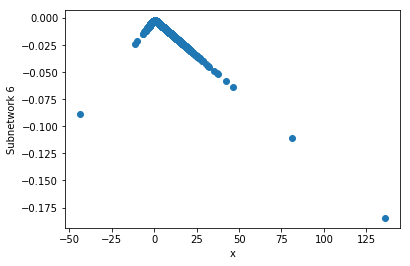

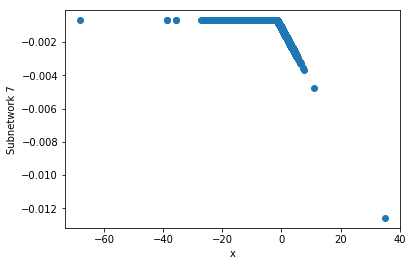

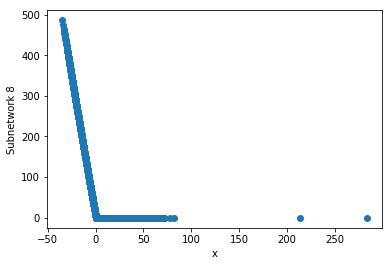

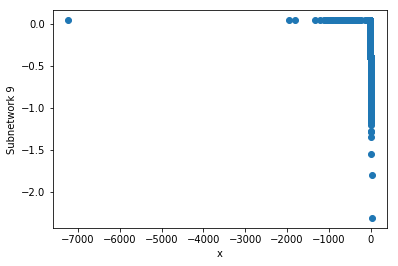

In [42]:
# Plot the ridge functions

Ridge_x = pd.read_csv(xnn_dir + "ridge_x_" + label + ".csv")
Ridge_y = pd.read_csv(xnn_dir + "ridge_y_" + label + ".csv")
Ridge_y = Ridge_y.applymap(lambda x: eval(x)[0])

Ridge_x.to_csv(xnn_dir + 'Results_hmda_Ridge_x_values.csv', index=False)
Ridge_y.to_csv(xnn_dir + 'Results_hmda_Ridge_y_values.csv', index=False)

for row_num in range(Ridge_y.shape[0]):
    plt.plot(Ridge_x.iloc[row_num,:], Ridge_y.iloc[row_num,:], 'o')
    plt.xlabel("x")
    plt.ylabel("Subnetwork " + str(row_num))
    plt.show()

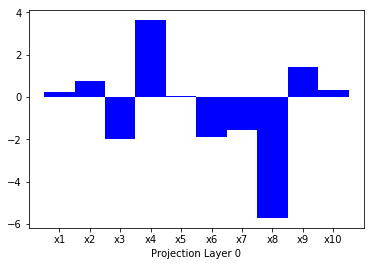

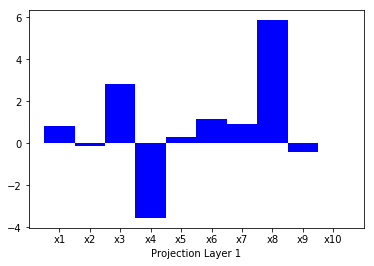

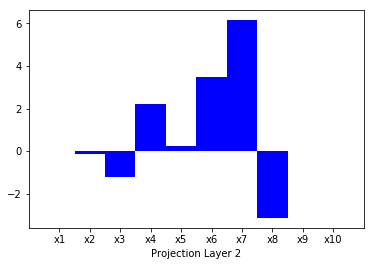

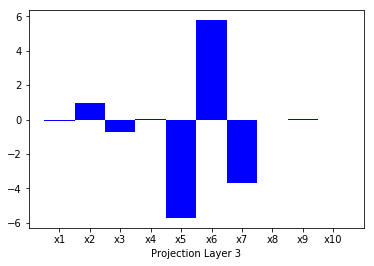

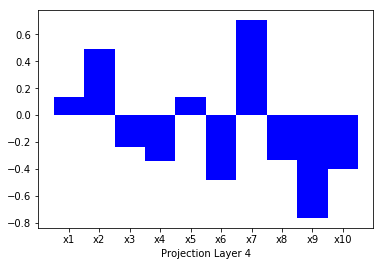

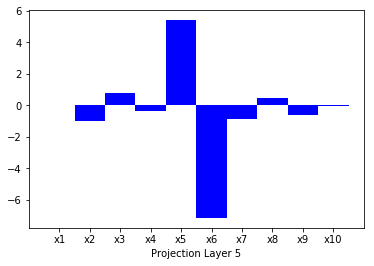

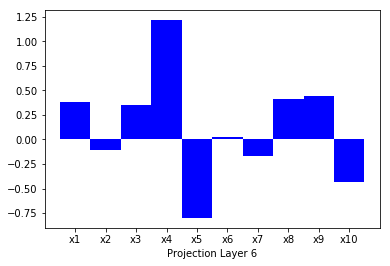

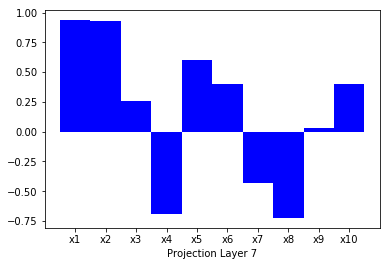

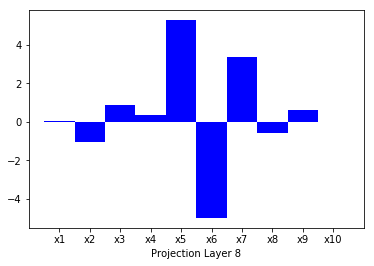

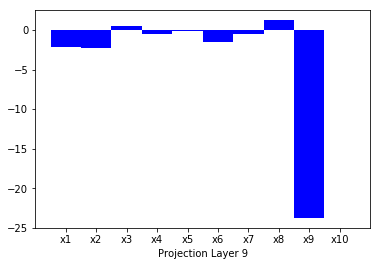

In [43]:
# Plot the projection layers

WP = pd.read_csv(xnn_dir + "wp_" + label + ".csv")

x = list(map(lambda x: 'x' + str(x+1), range(len(WP))))

WP.to_csv(xnn_dir + "Results_hmda_projection_layer.csv", index=False)

titles = ["Projection Layer " + str(ii) for ii in range(len(WP))]

for ind in range(len(WP)):
    plt.bar(x, WP.iloc[ind,:], 1, color="blue")
    plt.xlabel(titles[ind])
    plt.ylabel("")
    plt.show()

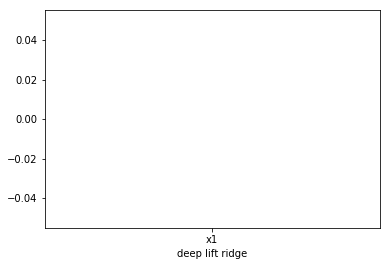

In [44]:
# Ridge scores

Scores = pd.read_csv(xnn_dir + "scores_" + label + ".csv")

# Print the scores
x = list(map(lambda x: 'x' + str(x+1), range(Scores.shape[1])))

titles = ["layerwise average input", "layerwise average ridge",
          "layerwise average input 2", "layerwise average ridge 2",
          "shap input", "deep lift input", "deep lift ridge"]

ind = 6
plt.bar(x, Scores.iloc[ind,:], 1, color="blue")
plt.xlabel(titles[ind])
plt.ylabel("")
plt.show()

In [45]:
# A few missing values caused problems with the score calculations
# they are recalculated at the end of the notebook
Scores


,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,inf,NaN,inf,inf,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.000328,-0.000529,0.000097,-0.013723,0.010216,0.054917,-0.044454,0.015028,-0.000868,0.003661
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
TEST.columns

Index(['Unnamed: 0', 'high_priced', 'term_360', 'conforming', 'black', 'asian',
       'white', 'amind', 'hipac', 'hispanic', 'non_hispanic', 'male', 'female',
       'agegte62', 'agelt62', 'debt_to_income_ratio_missing',
       'loan_amount_std', 'loan_to_value_ratio_std',
       'no_intro_rate_period_std', 'intro_rate_period_std',
       'property_value_std', 'income_std', 'debt_to_income_ratio_std', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype='object')

In [47]:
TEST.iloc[0:4,]
TEST = TEST.rename(columns={"0": "probability", 
                            "1": Feature_names[0]+"_Shapley_score",
                            "2": Feature_names[1]+"_Shapley_score",
                            "3": Feature_names[2]+"_Shapley_score",
                            "4": Feature_names[3]+"_Shapley_score",
                            "5": Feature_names[4]+"_Shapley_score",
                            "6": Feature_names[5]+"_Shapley_score", 
                            "7": Feature_names[6]+"_Shapley_score",
                            "8": Feature_names[7]+"_Shapley_score",
                            "9": Feature_names[8]+"_Shapley_score",
                            "10": Feature_names[9]+"_Shapley_score",
                            "11": "Intercept_Shapley_score"})
#Feature_names

In [48]:
TEST.columns

TEST.to_csv(xnn_dir + "Results_hmda_test_set.csv", index=False)

In [49]:
FEATURES = pd.read_csv(xnn_dir + "feature_output3_BLDS_run200.csv")

In [50]:
# Make sure there aren't missing values in the deep lift scores
# for the ridge functions

features = len(Feature_names)
lift_average_ridge=np.array([0.0]*features)

count = 0
for ii in range(len(FEATURES)):
    vector =  np.abs(np.array(FEATURES.iloc[ii, (3*features):(4*features)]))
    if (sum(np.isfinite(vector))==features) and (sum(np.isnan(vector))==0):
        lift_average_ridge += vector
        count+=1

lift_average_ridge = lift_average_ridge/count

In [51]:
lift_average_ridge

array([-1.39015805e-02,  4.26574329e-05, -8.01493643e-03, -2.09466256e-03,
        1.10749748e-05,  3.30522502e-03, -8.71576358e-07, -3.56288456e-08,
       -8.11010686e-04,  6.55206296e-03])

In [52]:
pd.DataFrame(lift_average_ridge).to_csv(xnn_dir + "Results_deep_lift_ridge_function_scores_hmda.csv")